# `pcxarray` NAIP example

`pcxarray` is a small Python package that provides a simple interface to interact with the Microsoft Planetary Computer Data Catalog. With this package, you can create queries using shapely geometries and retrieve results in GeoDataFrames such that you can examine item metadata and select assets for download, as well as automatically load and preprocess data into xarray DataArray.

This example demonstrates how to use `pcxarray` to query NAIP imagery and load it into an xarray DataArray. The state of Mississippi is used as an example, but you can modify the code to query other states or regions.

In [1]:
from pcxarray import pc_query, prepare_data, query_and_prepare
from pcxarray.utils import create_grid, load_census_shapefile

## Creating polygon grids

You can use the `pcxarray` package to create polygon grids to subdivide a larger area into smaller sections. This is useful for processing large datasets in manageable chunks. The following code creates a grid of polygons over the state of Mississippi:

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
44,3,6,28,01779790,28,0400000US28,MS,Mississippi,00,G4000,A,121534116434,3914302814,+32.6864714,-089.6561377,"POLYGON ((624275.848 1270567.752, 624241.051 1..."


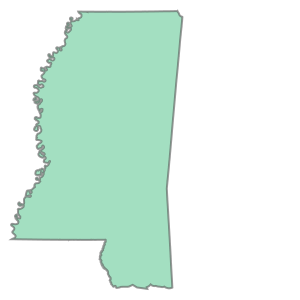

In [2]:
states_gdf = load_census_shapefile(verify=False) # using verify=False due to local SSL issue, do not use in production
ms_gdf = states_gdf[states_gdf['STUSPS'] == 'MS']
ms_gdf = ms_gdf.to_crs(3814) # Mississippi Transveres Mercator (https://epsg.io/3814)
display(ms_gdf)
display(ms_gdf.iloc[0].geometry)

,geometry
0,"POLYGON ((575558.025 1038674.182, 576558.025 1..."
1,"POLYGON ((576558.025 1038674.182, 577558.025 1..."
2,"POLYGON ((577558.025 1038674.182, 578558.025 1..."
3,"POLYGON ((578558.025 1038674.182, 579558.025 1..."
4,"POLYGON ((579558.025 1038674.182, 580558.025 1..."
...,...
126807,"POLYGON ((636558.025 1577674.182, 637558.025 1..."
126808,"POLYGON ((637558.025 1577674.182, 638558.025 1..."
126809,"POLYGON ((638558.025 1577674.182, 639558.025 1..."
126810,"POLYGON ((639558.025 1577674.182, 640558.025 1..."


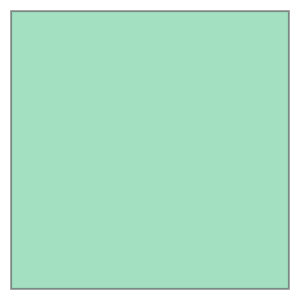

In [3]:
grid_gdf = create_grid(
    ms_gdf.iloc[0].geometry,
    crs=ms_gdf.crs,
    cell_size=1000,  # each cell is 1km x 1km
    clip_to_polygon=False, # set to True to clip cells on the polygon boundary to the polygon itself
)
display(grid_gdf)

selected_geom = grid_gdf.iloc[10000].geometry
display(selected_geom)

## Querying Planetary Computer NAIP data

Now, we can use the `pcxarray` package to query NAIP data for the state of Mississippi. The GeoDataFrame created in the previous step is used to define the area of interest. For the purposes of this notebook, we will only query NAIP data for one polygon in the grid.

In [4]:
# now, query files
items_gdf = pc_query(
    collections='naip',
    geometry=selected_geom,
    crs=grid_gdf.crs,
    datetime='2023'
)

# Display the queried items to get a broad overview of what is contained
# NOTE: Pystac items contain a lot of metadata, and most of it is not relevant for downstream processing.
# I leave it up to the end user to filter out the specific metadata based on their needs.
display(items_gdf.columns)
display(items_gdf)

Index(['type', 'stac_version', 'stac_extensions', 'id', 'bbox',
       'properties.gsd', 'properties.datetime', 'properties.naip:year',
       'properties.proj:bbox', 'properties.providers', 'properties.naip:state',
       'properties.proj:shape', 'properties.proj:centroid.lat',
       'properties.proj:centroid.lon', 'properties.proj:transform',
       'properties.proj:code', 'links', 'assets.image.href',
       'assets.image.type', 'assets.image.title', 'assets.image.eo:bands',
       'assets.image.roles', 'assets.thumbnail.href', 'assets.thumbnail.type',
       'assets.thumbnail.title', 'assets.thumbnail.roles',
       'assets.tilejson.href', 'assets.tilejson.type', 'assets.tilejson.title',
       'assets.tilejson.roles', 'assets.rendered_preview.href',
       'assets.rendered_preview.type', 'assets.rendered_preview.title',
       'assets.rendered_preview.rel', 'assets.rendered_preview.roles',
       'collection', 'geometry'],
      dtype='object')

,type,stac_version,stac_extensions,id,bbox,properties.gsd,properties.datetime,properties.naip:year,properties.proj:bbox,properties.providers,...,assets.tilejson.type,assets.tilejson.title,assets.tilejson.roles,assets.rendered_preview.href,assets.rendered_preview.type,assets.rendered_preview.title,assets.rendered_preview.rel,assets.rendered_preview.roles,collection,geometry
0,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,ms_m_3008915_nw_16_060_20230701_20240103,"[-89.253589, 30.809596, -89.183951, 30.877901]",0.6,2023-07-01T16:00:00Z,2023,"[284556.0, 3410670.0, 291072.0, 3418116.0]",[{'url': 'https://www.fsa.usda.gov/programs-an...,...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],naip,"POLYGON ((554157.957 1112863.988, 553974.736 1..."
1,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,ms_m_3008915_ne_16_060_20230701_20240103,"[-89.191032, 30.809639, -89.121497, 30.877913]",0.6,2023-07-01T16:00:00Z,2023,"[290538.0, 3410556.0, 297048.0, 3418002.0]",[{'url': 'https://www.fsa.usda.gov/programs-an...,...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],naip,"POLYGON ((560133.48 1112897.003, 559950.208 11..."
2,Feature,1.1.0,[https://stac-extensions.github.io/eo/v1.1.0/s...,ms_m_3008907_se_16_060_20230701_20240103,"[-89.191074, 30.872095, -89.121492, 30.940371]",0.6,2023-07-01T16:00:00Z,2023,"[290670.0, 3417480.0, 297180.0, 3424926.0]",[{'url': 'https://www.fsa.usda.gov/programs-an...,...,application/json,TileJSON with default rendering,[tiles],https://planetarycomputer.microsoft.com/api/da...,image/png,Rendered preview,preview,[overview],naip,"POLYGON ((560095.021 1119820.568, 559911.477 1..."


## Downloading and loading NAIP data
Once we have the query results, we can download the NAIP data and load it into an xarray dataarray using the prepare_data function. The returned imagery is in the form of an xarray DataArray, which contains the NAIP imagery data for the specified geometry in the given coordinate reference system. If the geometry is not completely contained by a single NAIP tile, a mosaic will automatically be created. `target_resolution` can be used to specify the resolution of the output data in the units of the CRS.

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


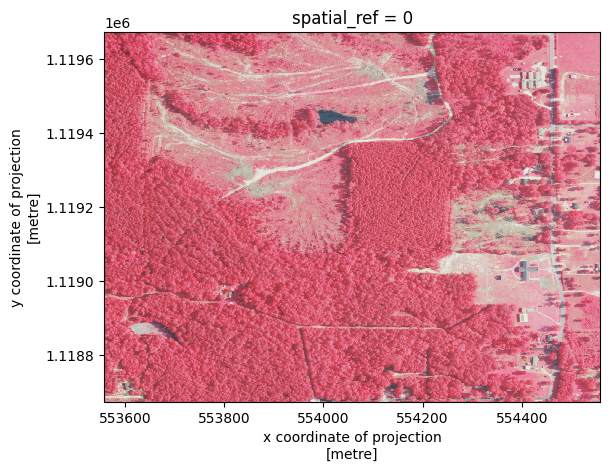

In [5]:
imagery = prepare_data(
    geometry=selected_geom,
    crs=grid_gdf.crs,
    items_gdf=items_gdf,
    target_resolution=1.0
)
imagery.sel(band=[4, 1, 2]).plot.imshow()

## Putting it all together

In most cases, you can combine the query/load steps into a single function call.

/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/dh2306/pcxarray/.venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:253: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


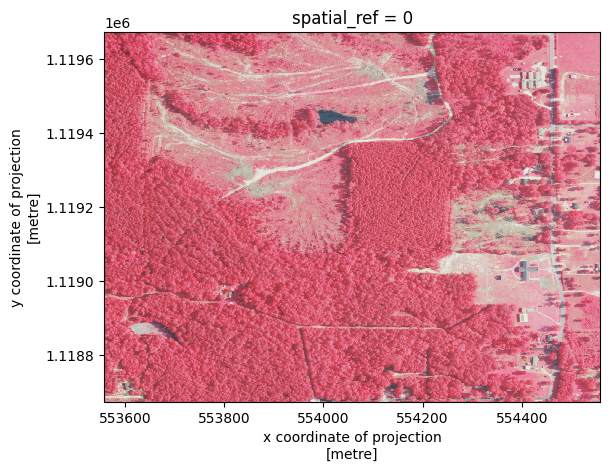

In [6]:
imagery = query_and_prepare(
    collections='naip',
    geometry=selected_geom,
    crs=grid_gdf.crs,
    datetime='2023',
    target_resolution=1.0
)
imagery.sel(band=[4, 1, 2]).plot.imshow()